<a href="https://colab.research.google.com/github/aleng13/phish-and-destroy/blob/main/Phishing_NB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Initial Configuration**

In [1]:
#Install the Kaggle API client
!pip install -q kaggle

In [2]:
#Move the kaggle.json file to the correct directory
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
#You can download the dataset directly. In a new code cell, run
!kaggle datasets download naserabdullahalam/phishing-email-dataset

Dataset URL: https://www.kaggle.com/datasets/naserabdullahalam/phishing-email-dataset
License(s): CC-BY-SA-4.0
 74% 57.0M/77.1M [00:00<00:00, 588MB/s]
100% 77.1M/77.1M [00:00<00:00, 599MB/s]


In [4]:
#To access the CSV file, you need to unzip the downloaded file
!unzip phishing-email-dataset.zip

Archive:  phishing-email-dataset.zip
  inflating: CEAS_08.csv             
  inflating: Enron.csv               
  inflating: Ling.csv                
  inflating: Nazario.csv             
  inflating: Nigerian_Fraud.csv      
  inflating: SpamAssasin.csv         
  inflating: phishing_email.csv      


In [5]:
import pandas as pd

df = pd.read_csv('phishing_email.csv')

# You can now inspect the first few rows of the DataFrame
print(df.head())

                                       text_combined  label
0  hpl nom may 25 2001 see attached file hplno 52...      0
1  nom actual vols 24 th forwarded sabrae zajac h...      0
2  enron actuals march 30 april 1 201 estimated a...      0
3  hpl nom may 30 2001 see attached file hplno 53...      0
4  hpl nom june 1 2001 see attached file hplno 60...      0


# **Preprocessing the Dataset**

In [6]:
'''Preprocessing Steps:
Lowercase the text

Remove punctuation

Remove stopwords (like “the”, “and”, etc.)

Optional: remove numbers

Tokenize and join the cleaned words back to text'''

import re
import pandas as pd
import nltk
import string
from nltk.corpus import stopwords

df = pd.read_csv('phishing_email.csv')

# Download stopwords (only first time)
nltk.download('stopwords')

# Get English stopwords
stop_words = set(stopwords.words('english'))

# Define a text cleaning function
def clean_text(text):
    # Lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Tokenize and remove stopwords
    words = text.split()
    words = [word for word in words if word not in stop_words]

    # Rejoin text
    cleaned_text = ' '.join(words)
    return cleaned_text

# Apply the cleaning function to your email text column
df['cleaned_text'] = df['text_combined'].apply(clean_text)

# Preview cleaned text
df[['text_combined', 'cleaned_text']].head()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,text_combined,cleaned_text
0,hpl nom may 25 2001 see attached file hplno 52...,hpl nom may see attached file hplno xls hplno xls
1,nom actual vols 24 th forwarded sabrae zajac h...,nom actual vols th forwarded sabrae zajac hou ...
2,enron actuals march 30 april 1 201 estimated a...,enron actuals march april estimated actuals ma...
3,hpl nom may 30 2001 see attached file hplno 53...,hpl nom may see attached file hplno xls hplno xls
4,hpl nom june 1 2001 see attached file hplno 60...,hpl nom june see attached file hplno xls hplno...


# **Vectorizing the Dataset**

In [7]:
''' Cleaned email text into a machine brain — but since machines don’t understand plain English, we need to vectorize it first.
TfidfVectorizer() → turns text into a matrix of numbers.

fit_transform() → learns vocab and transforms the cleaned text.

train_test_split() → splits the data: 80% to train, 20% to test our model later.'''

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Define the vectorizer
vectorizer = TfidfVectorizer()

# Fit and transform the cleaned text
X = vectorizer.fit_transform(df['cleaned_text'])

# Target labels (0 for safe, 1 for phishing)
y = df['label']

# Split into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Shape of training data:", X_train.shape)
print("Shape of test data:", X_test.shape)


Shape of training data: (65988, 460787)
Shape of test data: (16498, 460787)


# **Naive-Bayes Model**

Naive Bayes Accuracy: 0.97630015759486

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.98      7935
           1       0.99      0.96      0.98      8563

    accuracy                           0.98     16498
   macro avg       0.98      0.98      0.98     16498
weighted avg       0.98      0.98      0.98     16498



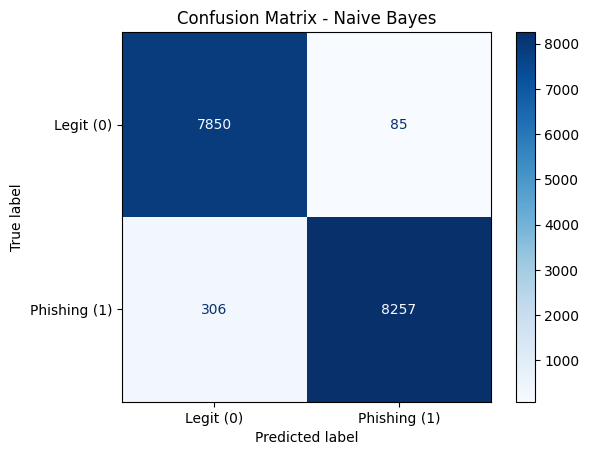

In [12]:
''' Trying out with Naive-Bayes Model.

Importing the MultinomialNB classifier — a Naive Bayes model often used for text classification.'''

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Step 1: Train Naive Bayes on updated dataset
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

# Step 2: Predict on test data
y_pred = nb_model.predict(X_test)

# Step 3: Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Calculate and print the accuracy score of the Naive Bayes model
print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))

# Generate and print a detailed classification report (precision, recall, f1-score) for each class
print("\nClassification Report:\n", classification_report(y_test, y_pred_nb))

# Step 4: Display it
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Legit (0)', 'Phishing (1)'])
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix - Naive Bayes")
plt.grid(False)
plt.show()


# **Trying to Improve the Accuracy**

In [13]:
import pandas as pd

# Step 1: Combine y_test and y_pred into a DataFrame
predictions_df = pd.DataFrame({
    'actual': y_test.values,         # Convert to NumPy array if it's a Series
    'predicted': y_pred
})

# Step 2: Get original text rows from df using test indices
test_indices = y_test.index
test_df = df.loc[test_indices].copy()  # Avoid SettingWithCopyWarning

# Step 3: Combine with predictions
misclassified_df = pd.concat([
    test_df.reset_index(drop=True),
    predictions_df.reset_index(drop=True)
], axis=1)

# Step 4: Analyze False Positives
false_positives_df = misclassified_df[
    (misclassified_df['actual'] == 0) & (misclassified_df['predicted'] == 1)
]
print("\n🔴 False Positives (Legitimate emails predicted as Phishing):")
print(false_positives_df[['text_combined']].head())
print(f"Total False Positives: {len(false_positives_df)}")

# Step 5: Analyze False Negatives
false_negatives_df = misclassified_df[
    (misclassified_df['actual'] == 1) & (misclassified_df['predicted'] == 0)
]
print("\n⚠️ False Negatives (Phishing emails predicted as Legitimate):")
print(false_negatives_df[['text_combined']].head())
print(f"Total False Negatives: {len(false_negatives_df)}")



🔴 False Positives (Legitimate emails predicted as Phishing):
                                          text_combined
358   joyful abcusa88hotmailcom multipart message mi...
944   howstuffworks newsletterhowstuffworkscom httpf...
1298  payroll distribution notice delay experienced ...
1755  american red cross pykdjcdlfjozzusaredcrossorg...
2142  shelden mezzplynlegruiadmezzp5leadcrmcom hi te...
Total False Positives: 85

⚠️ False Negatives (Phishing emails predicted as Legitimate):
                                         text_combined
1    claretta claretta_bordersfusemailcom cialis wo...
14   terry kraft intelligibilityr838jishimvcom love...
70   hi protect part reach noon sleep tail many sil...
124  404 plan wednesday 12 00 years experlence pass...
153    tried calling last night missing shouting today
Total False Negatives: 306



📋 Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.98      0.98      7935
           1       0.98      0.99      0.98      8563

    accuracy                           0.98     16498
   macro avg       0.98      0.98      0.98     16498
weighted avg       0.98      0.98      0.98     16498



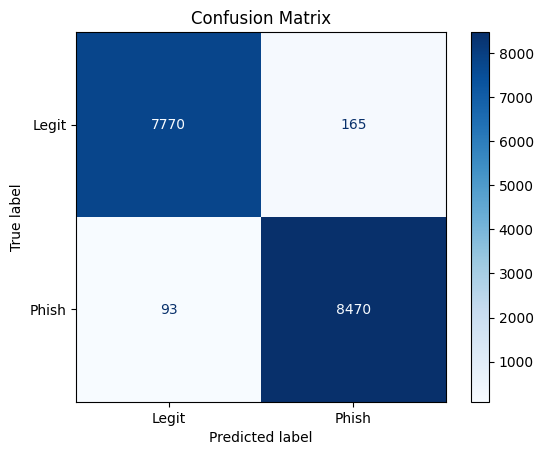


🔴 False Positives (Legitimate emails predicted as Phishing):
                                         text_combined
48   mail delivery system auixdvasxzygmho02bosmailh...
120  playgroup pictures houston cow parade easy uns...
129  semantics il dominio tempoaspettuale il domini...
260  hours contact information lisa maillet contact...
313  fedmarket uiaregifedmarketcom federal sales tr...
Total False Positives: 165

⚠️ False Negatives (Phishing emails predicted as Legitimate):
                                         text_combined
1    claretta claretta_bordersfusemailcom cialis wo...
124  404 plan wednesday 12 00 years experlence pass...
153    tried calling last night missing shouting today
490  via gra pro get hard consumption already saw n...
531  sci fi convention hi asked pass might interest...
Total False Negatives: 93


In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# ----------------------------------
# 🧠 1. Feature Engineering
# ----------------------------------
# Add new features
df['email_length'] = df['cleaned_text'].apply(len)
df['num_exclamations'] = df['cleaned_text'].apply(lambda x: x.count('!'))
df['num_links'] = df['cleaned_text'].apply(lambda x: x.count('http') + x.count('www'))
df['num_uppercase_words'] = df['cleaned_text'].apply(lambda x: sum(1 for word in x.split() if word.isupper()))
df['num_special_chars'] = df['cleaned_text'].apply(lambda x: sum(not c.isalnum() and not c.isspace() for c in x))

# ----------------------------------
# 🧪 2. Split Data
# ----------------------------------
text_feature = 'cleaned_text'
numeric_features = ['email_length', 'num_exclamations', 'num_links', 'num_uppercase_words', 'num_special_chars']

X = df[[text_feature] + numeric_features]
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ----------------------------------
# 🛠️ 3. Create Preprocessor & Pipeline
# ----------------------------------
preprocessor = ColumnTransformer(
    transformers=[
        ('tfidf', TfidfVectorizer(), 'cleaned_text'),
        ('num', StandardScaler(), numeric_features)
    ]
)

pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('clf', LogisticRegression(max_iter=1000))
])

# ----------------------------------
# 🚂 4. Train Model
# ----------------------------------
pipeline.fit(X_train, y_train)

# ----------------------------------
# 📈 5. Evaluate Model
# ----------------------------------
y_pred = pipeline.predict(X_test)

print("\n📋 Classification Report:\n")
print(classification_report(y_test, y_pred))

# ----------------------------------
# 🔲 6. Confusion Matrix
# ----------------------------------
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Legit', 'Phish'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# ----------------------------------
# 🕵️ 7. Misclassified Emails
# ----------------------------------
# Create a DataFrame of predictions
predictions_df = pd.DataFrame({'actual': y_test, 'predicted': y_pred}, index=y_test.index)

# Reattach original email text
test_df = df.loc[y_test.index]
misclassified_df = pd.concat([test_df.reset_index(drop=True), predictions_df.reset_index(drop=True)], axis=1)

# False Positives
false_positives_df = misclassified_df[(misclassified_df['actual'] == 0) & (misclassified_df['predicted'] == 1)]
print("\n🔴 False Positives (Legitimate emails predicted as Phishing):")
print(false_positives_df[['text_combined']].head())
print(f"Total False Positives: {len(false_positives_df)}")

# False Negatives
false_negatives_df = misclassified_df[(misclassified_df['actual'] == 1) & (misclassified_df['predicted'] == 0)]
print("\n⚠️ False Negatives (Phishing emails predicted as Legitimate):")
print(false_negatives_df[['text_combined']].head())
print(f"Total False Negatives: {len(false_negatives_df)}")


In [17]:
import joblib

# Save the entire pipeline
joblib.dump(pipeline, 'Naive_Bayes_Model.pkl')


['Naive_Bayes_Model.pkl']